An algorithm to find the best moving average for stock trading

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 42.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=c9e43c4b9338ff1c79167e8138518ceb0732c14c75038ac1593aced9f25f20d3
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import datetime

In [3]:
plt.rcParams['figure.figsize'] = [10, 7]

plt.rc('font', size=14)

In [5]:
np.random.seed(0)

In [6]:
y = np.arange(0,100,1) + np.random.normal(0,10,100)

In [7]:
sma = pd.Series(y).rolling(20).mean()

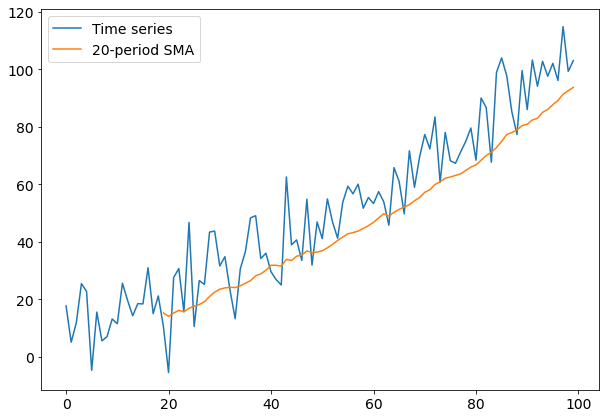

In [8]:
plt.plot(y,label="Time series")
plt.plot(sma,label="20-period SMA")

plt.legend()
plt.show()

In [20]:
n_forward = 40
name = 'GLD'
start_date = "2010-01-01"
end_date = "2020-06-15"

In [21]:
ticker = yfinance.Ticker("FB")
data = ticker.history(interval="1d",start='2013-04-01',end=end_date)

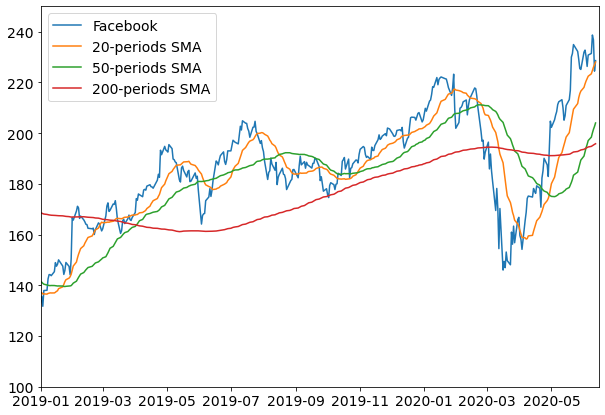

In [22]:
plt.plot(data['Close'],label='Facebook')


plt.plot(data['Close'].rolling(20).mean(),label = "20-periods SMA")
plt.plot(data['Close'].rolling(50).mean(),label = "50-periods SMA")
plt.plot(data['Close'].rolling(200).mean(),label = "200-periods SMA")

plt.legend()
plt.xlim((datetime.date(2019,1,1),datetime.date(2020,6,15)))
plt.ylim((100,250))
plt.show()

In [24]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)

data['Forward Close'] = data['Close'].shift(-n_forward)

data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [25]:
result = []
train_size = 0.6

for sma_length in range(20,500):
  
  data['SMA'] = data['Close'].rolling(sma_length).mean()
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()

  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']

  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()

  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length,
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

In [26]:
result.sort(key = lambda x : -x['training_forward_return'])

In [27]:
result[0]

{'p-value': 0.47736695370236537,
 'sma_length': 136,
 'test_forward_return': 0.012172903281716527,
 'training_forward_return': 0.010072331172651858}

In [28]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

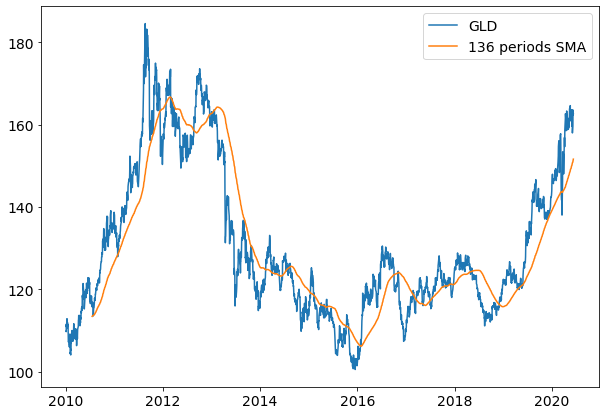

In [29]:
plt.plot(data['Close'],label=name)

plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma))

plt.legend()
plt.show()

Rolling Average Trading Strategy with Python

The purpose of this script is to implement a very simple trading strategy with Python. This strategy is based on the difference between slow and fast moving averages on the adjusted closed prices of shares. First we describe the strategy in detail explaining various features and then we optimize it using Python libraries.

In [30]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yfinance as yf 
yf.pdr_override() 
sns.set()
import warnings
warnings.filterwarnings('ignore')
from itertools import product

In [ ]:
stock =['^GSPC']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data = pdr.get_data_yahoo(stock, start=start, end=end)
data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.dropna(inplace=True)
data.head(5)
# data.to_csv('data.cvs') If we want to save the data

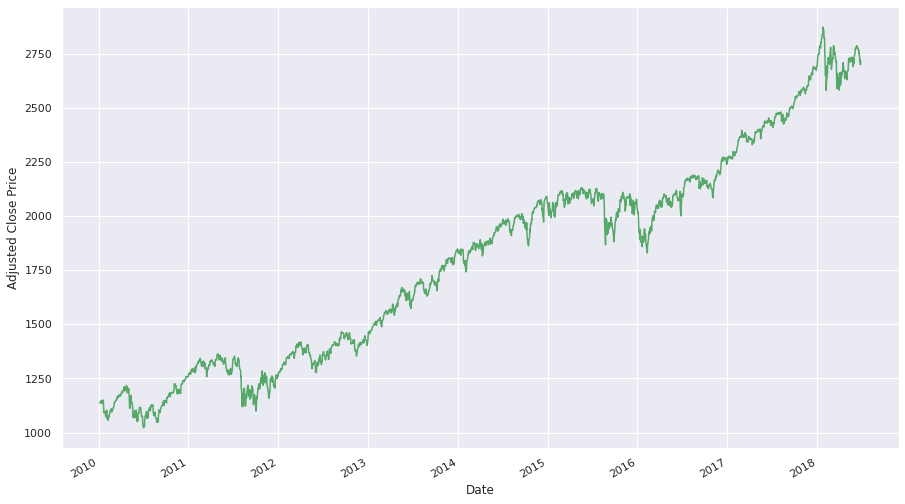

In [32]:
plt.figure(figsize = (15,9))
data['Adj Close'].plot(c = 'g')
plt.ylabel('Adjusted Close Price')
plt.show()

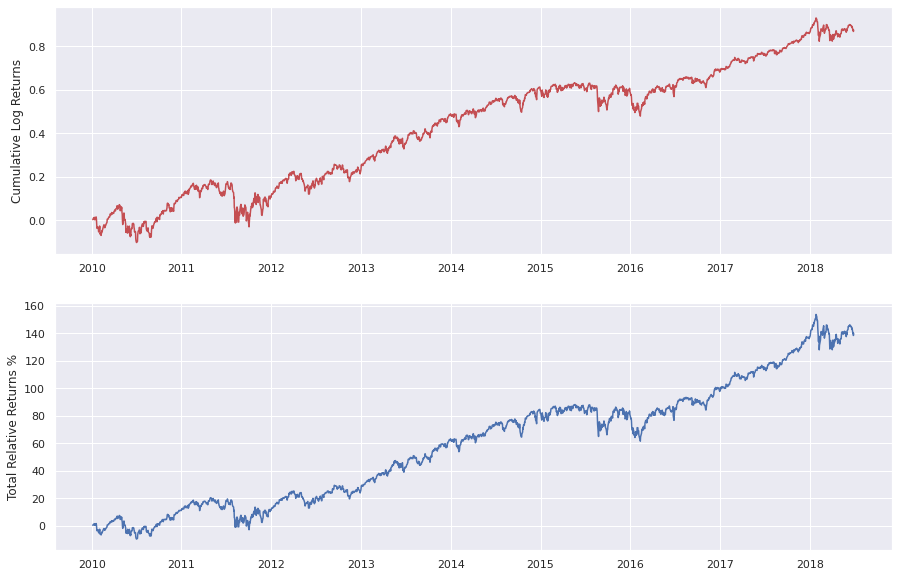

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

ax1.plot(data['Log Returns'].cumsum(), c = 'r')
ax1.set_ylabel('Cumulative Log Returns')

ax2.plot(100*(np.exp(data['Log Returns'].cumsum())-1))
ax2.set_ylabel('Total Relative Returns %')

plt.show()

In [34]:
MAF = 42
MAS =252

data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,MASlow,MAFast
Date,,,,,,,,,
2011-01-03,1257.619995,1276.170044,1257.619995,1271.869995,1271.869995,4286670000,0.011251,1140.516624,1223.431899
2011-01-04,1272.949951,1274.119995,1262.660034,1270.199951,1270.199951,4796420000,-0.001314,1141.047100,1225.151899
2011-01-05,1268.780029,1277.630005,1265.359985,1276.560059,1276.560059,4764920000,0.004995,1141.600354,1226.473328
2011-01-06,1276.290039,1278.170044,1270.430054,1273.849976,1273.849976,4844100000,-0.002125,1142.124798,1227.616185
2011-01-07,1274.410034,1276.829956,1261.699951,1271.500000,1271.500000,4963110000,-0.001846,1142.626862,1228.764994


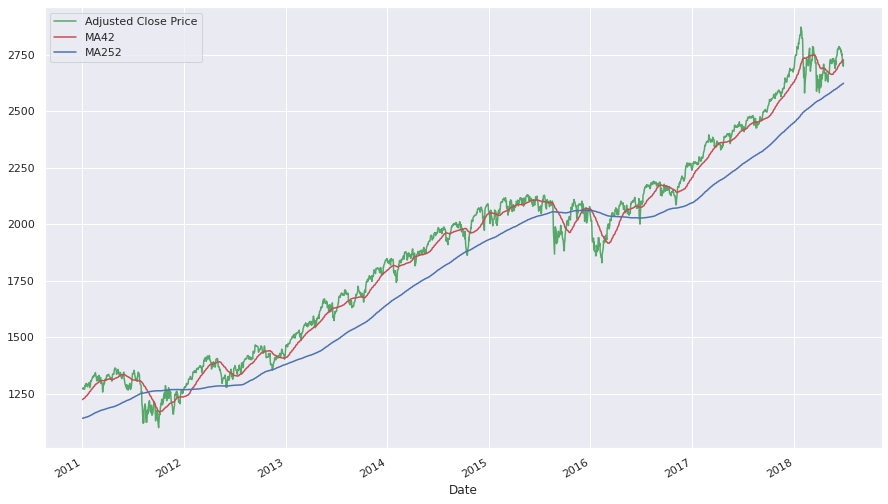

In [35]:
plt.figure(figsize= (15,9))
data['Adj Close'].plot(color = 'g', label = 'Adjusted Close Price')
data['MAFast'].plot(color = 'r', label = 'MA{}'.format(MAF) )
data['MASlow'].plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

In [36]:
data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,MASlow,MAFast,Signal
Date,,,,,,,,,,
2011-01-03,1257.619995,1276.170044,1257.619995,1271.869995,1271.869995,4286670000,0.011251,1140.516624,1223.431899,1
2011-01-04,1272.949951,1274.119995,1262.660034,1270.199951,1270.199951,4796420000,-0.001314,1141.047100,1225.151899,1
2011-01-05,1268.780029,1277.630005,1265.359985,1276.560059,1276.560059,4764920000,0.004995,1141.600354,1226.473328,1
2011-01-06,1276.290039,1278.170044,1270.430054,1273.849976,1273.849976,4844100000,-0.002125,1142.124798,1227.616185,1
2011-01-07,1274.410034,1276.829956,1261.699951,1271.500000,1271.500000,4963110000,-0.001846,1142.626862,1228.764994,1


 1    1642
-1     243
Name: Signal, dtype: int64


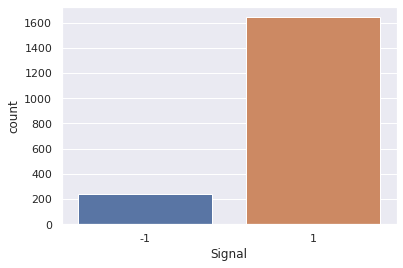

In [37]:
sns.countplot(data['Signal'])
print(data['Signal'].value_counts())

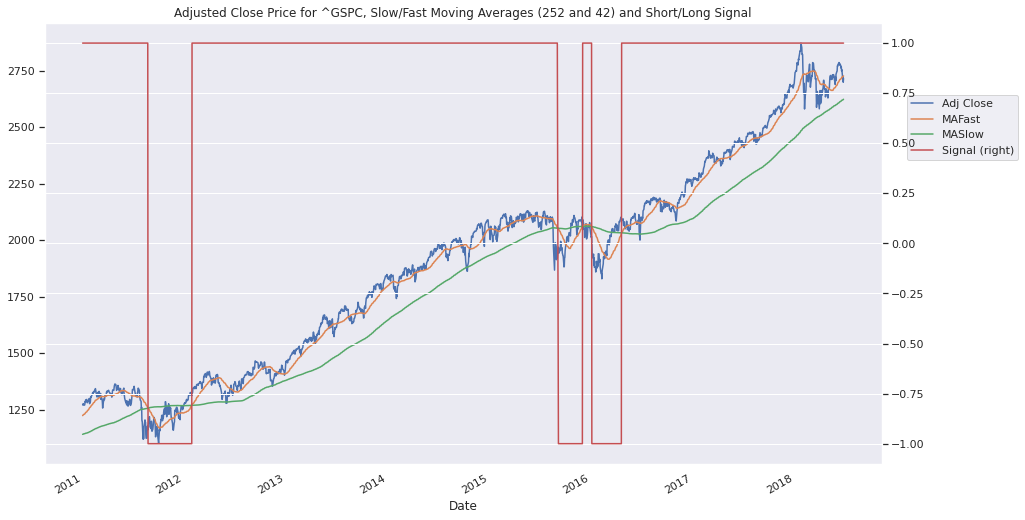

In [38]:
Ax = data[['Adj Close','MAFast','MASlow','Signal']].plot(secondary_y='Signal',figsize=(15,9),title='Adjusted Close Price for {}, Slow/Fast Moving Averages ({} and {}) and Short/Long Signal'.format(stock[0],MAS,MAF))
#Ax.title('Hello')
Ax.get_legend().set_bbox_to_anchor((1.17, 0.85))

In [39]:
data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
data.dropna(inplace=True)

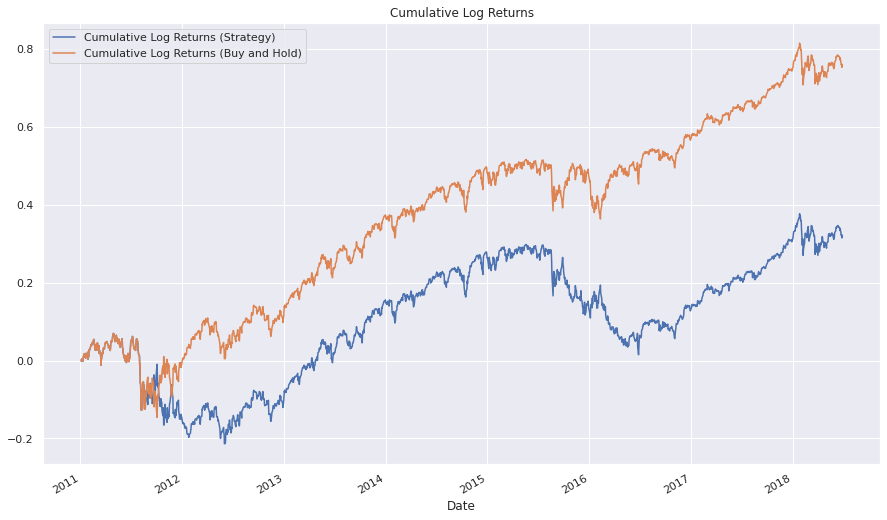

In [40]:
plt.figure(figsize = (15,9))
data['Strategy Log Returns'].cumsum().plot(label = 'Cumulative Log Returns (Strategy)')
data['Log Returns'].cumsum().plot(label = 'Cumulative Log Returns (Buy and Hold)')
plt.title('Cumulative Log Returns')
plt.legend()
plt.show()

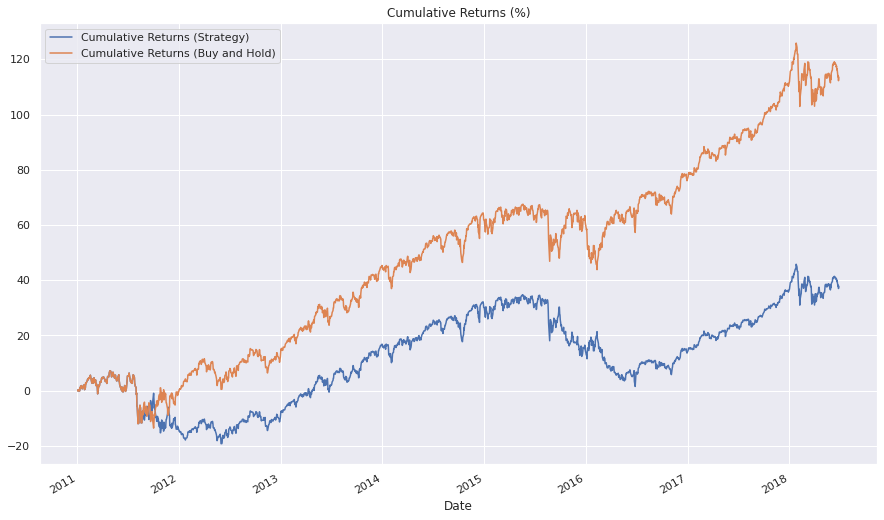

In [41]:
#print('Total Buy and Hold return (%) is : ', 100*(np.exp(data['Log Returns'].sum())-1).round(4),'%')
#print('Total strategy return (%) is : ', 100*(np.exp(data['Strategy Log Returns'].sum())-1).round(4),'%')

plt.figure(figsize = (15,9))
(100*(np.exp(data['Strategy Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Strategy)')
(100*(np.exp(data['Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Buy and Hold)')
plt.title('Cumulative Returns (%)')
plt.legend()
plt.show()

In [42]:
print('Total Returns')
print(25*'===')
print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')

Total Returns
Market Total Return: 113.568 %
Strategy Total Return: 37.832 %


In [43]:
print('Annualized Volatility')
print(25*'===')
print('Market Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[0],'%')
print('Strategy Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[1],'%')

Annualized Volatility
Market Volatility: 0.14383 %
Strategy Volatility: 0.14394 %


In [44]:
def MA_Strategy(stock,start,end,MAF,MAS):
    data = pdr.get_data_yahoo(stock, start=start, end=end)
    data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data.dropna(inplace=True)
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # We show the results:
    
    data[['Adj Close','MAFast','MASlow','Signal']].plot(secondary_y='Signal',figsize=(15,9),title='Adjusted Close Price for {}, Slow/Fast Moving Averages ({} and {}) and Short/Long Signal'.format(stock[0],MAS,MAF)).get_legend().set_bbox_to_anchor((1.17, 0.85))

    plt.figure(figsize = (15,9))
    (100*(np.exp(data['Strategy Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Strategy)')
    (100*(np.exp(data['Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Buy and Hold)')
    plt.title('Cumulative Returns (%): {}'.format(stock[0]))
    plt.legend()
    plt.show()
    
    print('\n')
    print('Total Returns:', stock[0])
    print(35*'===')
    print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
    print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')
    print('\n')
    print('Annualized Volatility:', stock[0])
    print(35*'===')
    print('Market Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[0],'%')
    print('Strategy Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[1],'%')

[*********************100%***********************]  1 of 1 completed


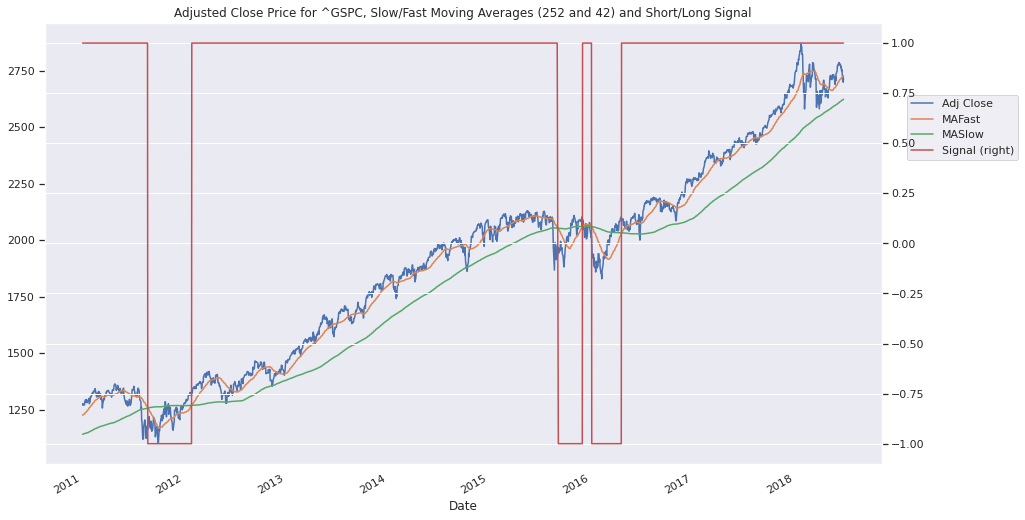

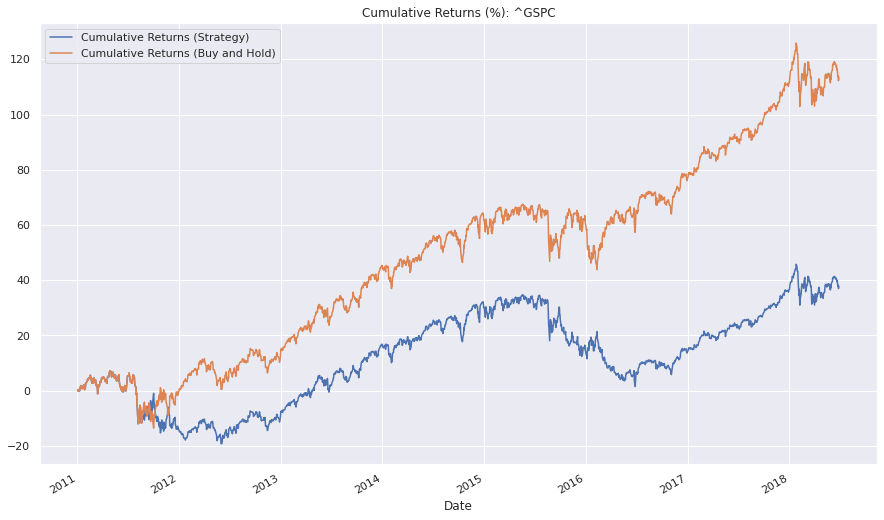



Total Returns: ^GSPC
Market Total Return: 113.568 %
Strategy Total Return: 37.832 %


Annualized Volatility: ^GSPC
Market Volatility: 0.14383 %
Strategy Volatility: 0.14394 %


In [45]:
stock =['^GSPC']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

[*********************100%***********************]  1 of 1 completed


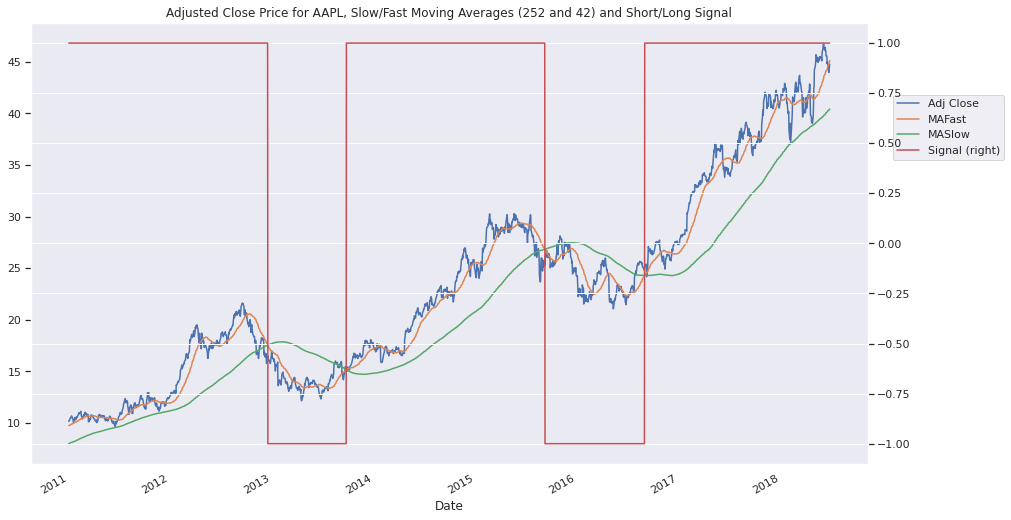

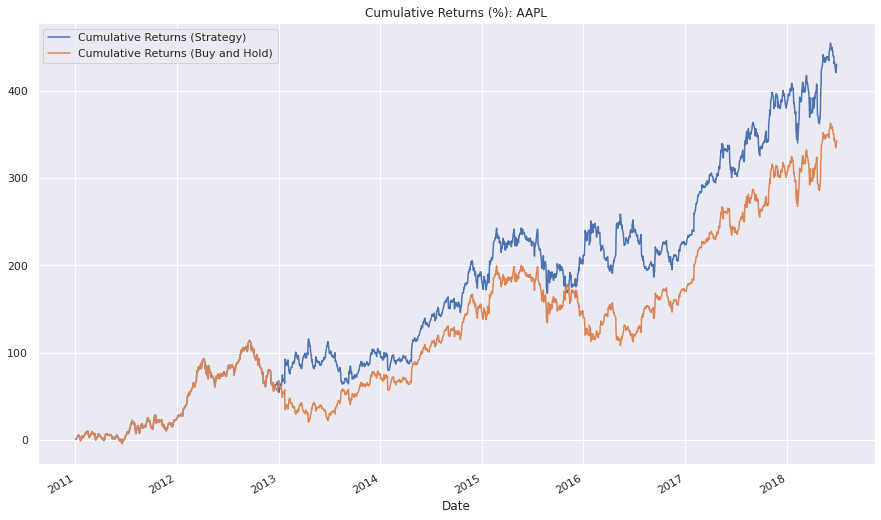



Total Returns: AAPL
Market Total Return: 343.012 %
Strategy Total Return: 430.587 %


Annualized Volatility: AAPL
Market Volatility: 0.25037 %
Strategy Volatility: 0.25028 %


In [46]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

[*********************100%***********************]  1 of 1 completed


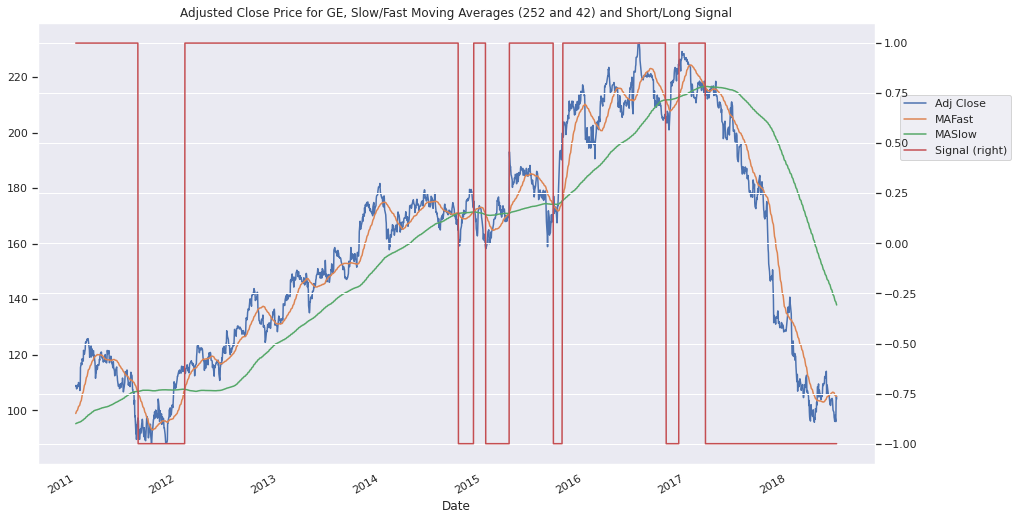

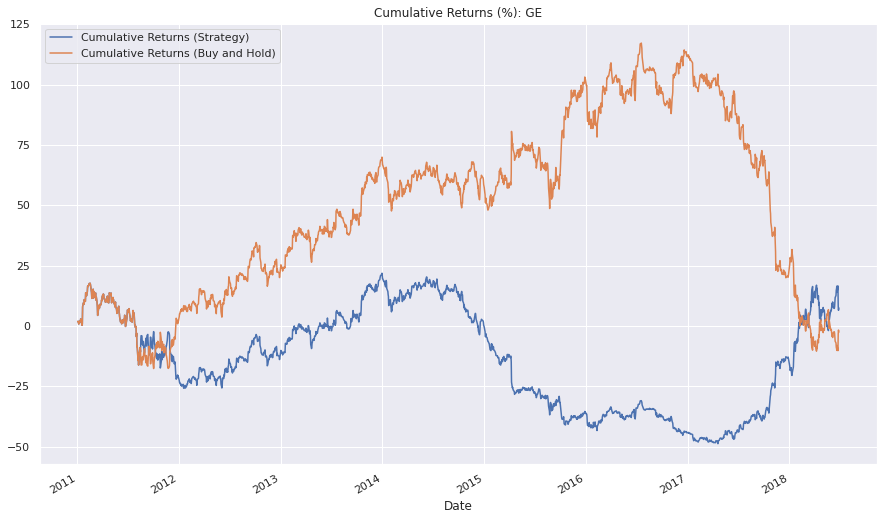



Total Returns: GE
Market Total Return: -2.6 %
Strategy Total Return: 7.499 %


Annualized Volatility: GE
Market Volatility: 0.21902 %
Strategy Volatility: 0.21902 %


In [47]:
stock =['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

In [48]:
def MA_Strategy_Short(stock,start,end,MAF,MAS):
    data = pdr.get_data_yahoo(stock, start=start, end=end)
    data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data.dropna(inplace=True)
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # We show the results:
    
    print('\n')
    print('Total Returns:', stock[0])
    print(35*'===')
    print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
    print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')

In [49]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 20
MAS =180

MA_Strategy_Short(stock,start,end,MAF,MAS)

[*********************100%***********************]  1 of 1 completed


Total Returns: AAPL
Market Total Return: 414.513 %
Strategy Total Return: 299.829 %


In [50]:
stock = ['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_apple = pdr.get_data_yahoo(stock, start=start, end=end) 
data_apple.to_csv('apple.cvs') 
pd.read_csv('apple.cvs').head(3)

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000


In [51]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 
stock = ['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

show = pd.DataFrame()
for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('apple.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)

In [52]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
233,180,85,414.513,681.684,267.171
97,170,40,466.321,672.269,205.948
219,190,80,405.307,590.941,185.634
29,240,15,355.747,539.452,183.704
147,220,55,384.112,561.342,177.230


[*********************100%***********************]  1 of 1 completed


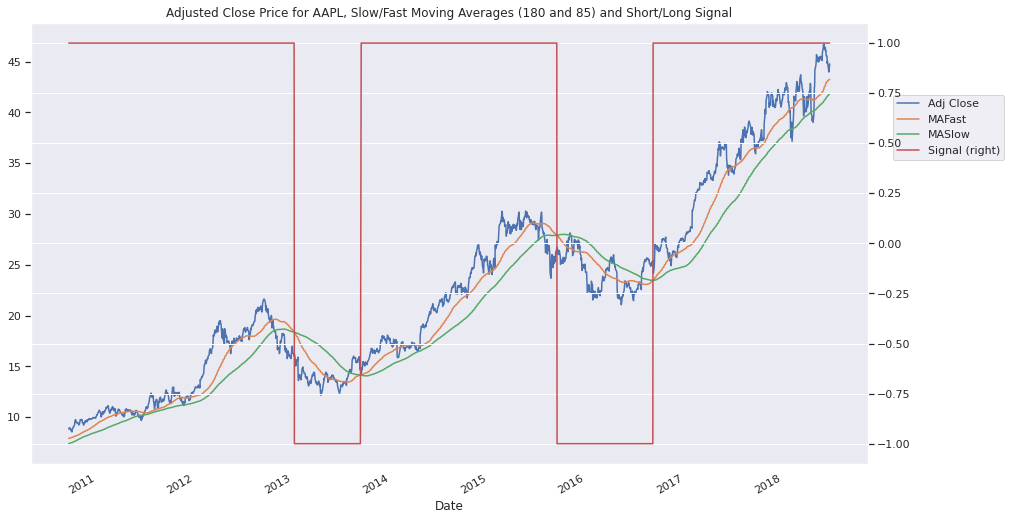

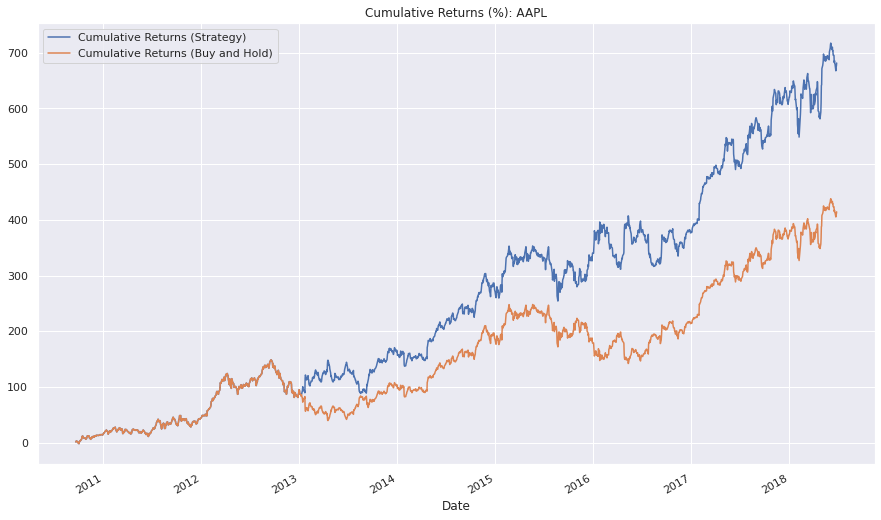



Total Returns: AAPL
Market Total Return: 414.513 %
Strategy Total Return: 681.684 %


Annualized Volatility: AAPL
Market Volatility: 0.24853 %
Strategy Volatility: 0.24832 %


In [53]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

MAS = 180
MAF = 85

MA_Strategy(stock,start,end,MAF,MAS)

In [54]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 

stock = ['^GSPC']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_GSPC = pdr.get_data_yahoo(stock, start=start, end=end) 
data_GSPC.to_csv('GSPC.cvs') 

show = pd.DataFrame()

for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('GSPC.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)

[*********************100%***********************]  1 of 1 completed


In [55]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
59,240,25,119.903,72.097,-47.806
179,240,65,119.903,64.411,-55.492
194,240,70,119.903,64.167,-55.736
193,230,70,125.220,68.458,-56.762
58,230,25,125.220,67.121,-58.099


In [56]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 

stock = ['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_GE = pdr.get_data_yahoo(stock, start=start, end=end) 
data_GE.to_csv('GE.cvs') 

show = pd.DataFrame()

for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('GE.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)

[*********************100%***********************]  1 of 1 completed


In [57]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
229,140,85,12.006,178.646,166.639
34,140,20,12.006,171.082,159.075
95,150,40,10.365,166.549,156.184
35,150,20,10.365,155.789,145.424
228,130,85,21.084,152.852,131.768


[*********************100%***********************]  1 of 1 completed


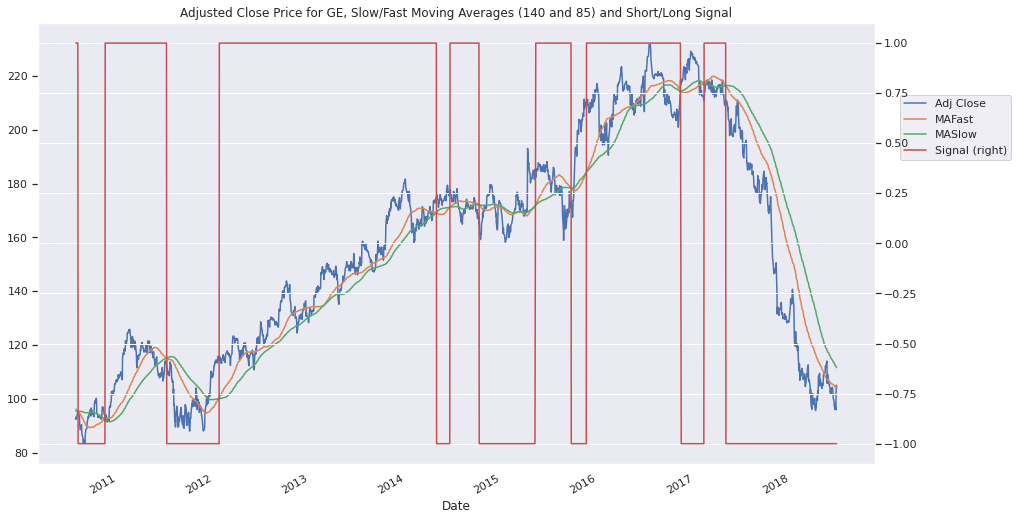

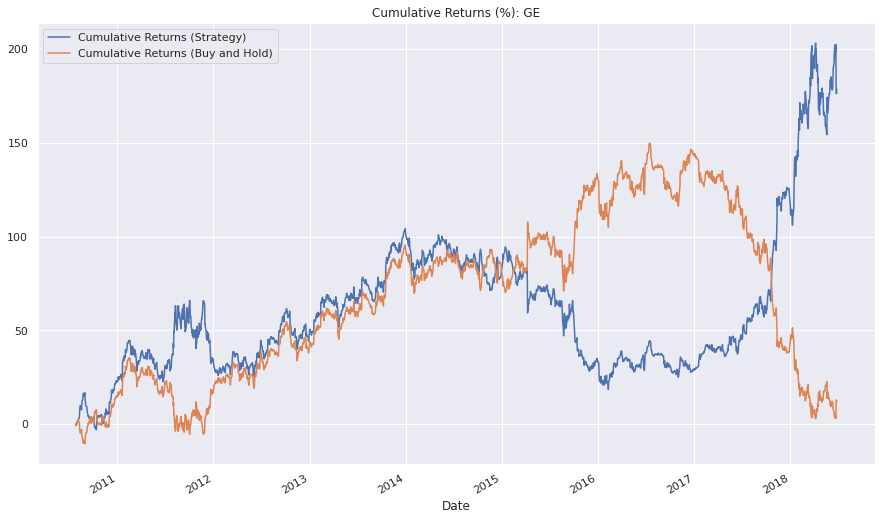



Total Returns: GE
Market Total Return: 12.006 %
Strategy Total Return: 178.646 %


Annualized Volatility: GE
Market Volatility: 0.21875 %
Strategy Volatility: 0.2186 %


In [58]:
stock =['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

MAS = 140
MAF = 85

MA_Strategy(stock,start,end,MAF,MAS)